In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
customers = pd.read_csv("data/olist_customers_dataset.csv")
orders = pd.read_csv("data/olist_orders_dataset.csv")
items = pd.read_csv("data/olist_order_items_dataset.csv")

In [57]:
data = items.merge(orders, on = "order_id")
data = data.merge(customers, on = "customer_id").drop('customer_id', axis=1)
data.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP


In [67]:
for col in data.columns:
    if col.endswith('_date'):
        data[col] = pd.to_datetime(data[col])
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])
data['order_approved_at'] = pd.to_datetime(data['order_approved_at'])

In [59]:
## Positive number means good, delivered earlier than expected
data['delivery_diff'] = data.order_estimated_delivery_date - data.order_delivered_customer_date

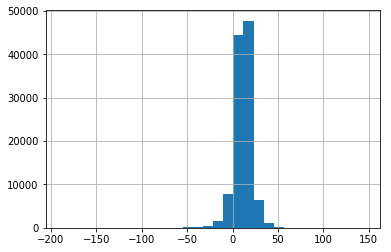

In [60]:
data.delivery_diff.dt.days.hist(bins = 30)

In [61]:
data["total_amt"] = data.price + data.freight_value
temp = data.groupby("customer_unique_id").agg({'total_amt': 'sum'})
temp.columns = ['total_amount']
data = data.merge(temp, on = "customer_unique_id").drop('total_amt', axis=1)

In [76]:
curr = max(data.order_purchase_timestamp) 

In [87]:
aggregation = {
    'order_purchase_timestamp': lambda x: curr-max(x),
    'order_id': 'nunique',
    'total_amount': 'sum'
}

rfm = data.groupby("customer_unique_id").agg(aggregation)

In [88]:
rfm.columns = ['recency','frequency','to_delete']
rfm['monetary'] = rfm.to_delete/rfm.frequency
rfm = rfm.drop('to_delete', axis=1)

In [89]:
rfm.head()

,recency,frequency,monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,115 days 22:10:30,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,118 days 21:55:30,1,27.19
0000f46a3911fa3c0805444483337064,541 days 12:01:54,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,325 days 12:37:16,1,43.62
0004aac84e0df4da2b147fca70cf8255,292 days 13:21:15,1,196.89


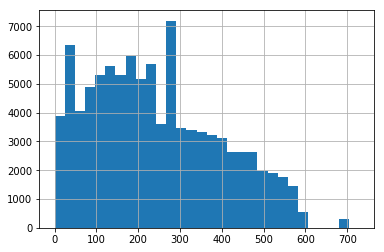

In [91]:
rfm.recency.dt.days.hist(bins=30)

In [99]:
rfm.frequency.value_counts()

1     92507
2      2673
3       192
4        29
5         9
6         5
7         3
16        1
9         1
Name: frequency, dtype: int64

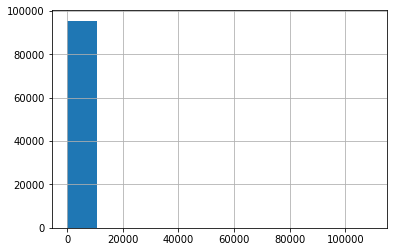

In [103]:
rfm.monetary.hist(bins=10)

In [105]:
data = data.merge(rfm, on = "customer_unique_id")

In [122]:
data["delivery_diff"] = data.delivery_diff.dt.days
data["recency"] = data.recency.dt.days

C:\Users\Cheong\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


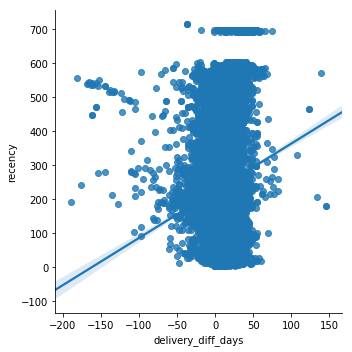

In [123]:
sns.lmplot(x = "delivery_diff", y = "recency", data = data)

C:\Users\Cheong\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


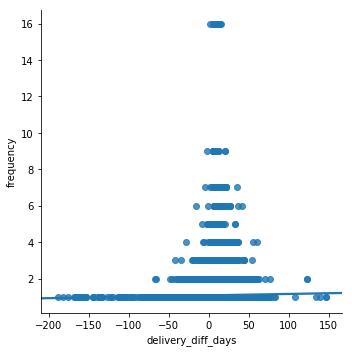

In [118]:
sns.lmplot(x = "delivery_diff", y = "frequency", data = data)

C:\Users\Cheong\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


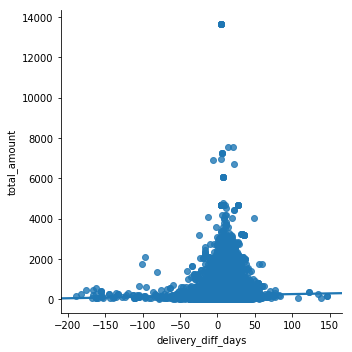

In [117]:
sns.lmplot(x = "delivery_diff", y = "total_amount", data = data)